In [56]:
import pandas as pd
import pickle
from vehicle_ownership import vehicle_ownership
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


data = pd.read_csv("data/consolidated/consolidated_data.csv")
with open("results/bootstrap_fits_one_step.pickle", "rb") as fp:   #Pickling
    bootstrap_fits = pickle.load(fp)

with open("results/prediction_residuals_one_step.pickle", "rb") as fp:   #Pickling
    residuals = pickle.load(fp)

betas_order = {}
counter = 0
for cc in data["Country Code"].sort_values().unique():
    betas_order[cc] = counter
    counter += 1

beta_0_idx = 6

In [57]:
len(bootstrap_fits)
bootstrap_fits = bootstrap_fits*100
len(bootstrap_fits)

10000

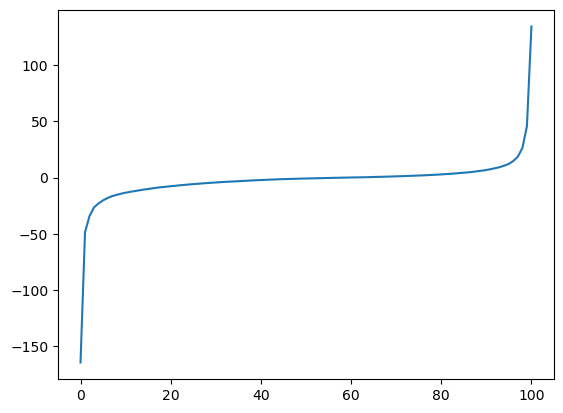

In [58]:
plt.plot(residuals)

In [59]:
def draw_residual_from_percentiles(residuals):
    x = np.random.rand(1)[0]
    x0 = int(x*100)    
    return residuals[x0] + (residuals[x0+1]-residuals[x0]) * (x*100-x0)

In [60]:
draw_residual_from_percentiles(residuals)

12.93295894377665

In [61]:
data

,Unnamed: 0,Country Code,Year,GDP,POP,POP-DENS,URBAN-POP-PERC,URBAN-POP-DENS,GDP_rising,GDP_falling,VEHICLE-STOCK,VEHICLE-STOCK-LAST,GDP-PER-CAP,VEHICLE-STOCK-PER-CAP,VEHICLE-STOCK-LAST-PER-CAP
0,227,AZE,1991,2.009841e+10,7271300.0,87.377579,53.441,2093.573094,0,1,298195.0,299254.0,2.764074,41.009861,41.155502
1,301,IDN,1991,2.885716e+11,185361228.0,102.320765,31.613,1304.643250,1,0,1999327.0,1781760.0,1.556807,10.786112,9.612366
2,303,IND,1991,4.701597e+11,888941756.0,298.985856,25.778,2258.203854,0,1,5818000.0,5303000.0,0.528898,6.544861,5.965520
3,312,JPN,1991,3.633171e+12,123964000.0,340.000000,77.473,1877.031268,1,0,38830236.0,36611244.0,29.308274,313.238005,295.337711
4,313,KAZ,1991,8.484057e+10,16451711.0,6.093903,56.175,1631.571534,0,1,903034.0,863900.0,5.156945,54.889975,52.511256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,6844,SVK,2021,1.008453e+11,5447247.0,113.633673,53.820,1575.301887,1,0,2834711.0,2774856.0,18.513085,520.393329,509.405210
1974,6845,SVN,2021,5.216408e+10,2108079.0,105.105828,55.427,1422.357804,1,0,1209397.0,1189832.0,24.744841,573.696242,564.415280
1975,6846,SWE,2021,5.668588e+11,10415811.0,25.603781,88.238,2213.958031,1,0,5684211.0,5630279.0,54.422918,545.729084,540.551187
1976,6854,THA,2021,4.387422e+11,71601103.0,140.232858,52.163,1805.867036,1,0,18640373.0,18127628.0,6.127590,260.336395,253.175262


In [62]:
#example countries: GBR, CHN
gdp_gbr = data.loc[data["Country Code"]=="GBR"]["GDP-PER-CAP"].values[-1] - np.arange(30)*0.1
gdp_chn = data.loc[data["Country Code"]=="CHN"]["GDP-PER-CAP"].values[-1] + np.arange(30)*0.8
years = np.linspace(2022,2050,num=29)
gdp_gbr
#plt.plot([*data.loc[data["Country Code"]=="GBR"]["GDP-PER-CAP"].values,*gdp_gbr])

array([45.334157, 45.234157, 45.134157, 45.034157, 44.934157, 44.834157,
       44.734157, 44.634157, 44.534157, 44.434157, 44.334157, 44.234157,
       44.134157, 44.034157, 43.934157, 43.834157, 43.734157, 43.634157,
       43.534157, 43.434157, 43.334157, 43.234157, 43.134157, 43.034157,
       42.934157, 42.834157, 42.734157, 42.634157, 42.534157, 42.434157])

In [63]:
# construct prediction intervals
bootstrap_preds = np.zeros((len(gdp_gbr),len(bootstrap_fits)))
data_test =  data.loc[(data["Country Code"]=="GBR")]
bootstrap_preds[0,:] = data.loc[(data["Country Code"]=="GBR")&(data["Year"]==2021)]["VEHICLE-STOCK-PER-CAP"].values[0]
upper = np.zeros(len(gdp_gbr))
lower = np.zeros(len(gdp_gbr))
iq_upper = np.zeros(len(gdp_gbr))
iq_lower = np.zeros(len(gdp_gbr))
predict = np.zeros(len(gdp_gbr))
predict[0] = data.loc[(data["Country Code"]=="GBR")&(data["Year"]==2021)]["VEHICLE-STOCK-PER-CAP"].values[0]
likely_percentile = 50
alpha = 0.05
for i in range(1,len(gdp_gbr)):
    for j,bf in enumerate(bootstrap_fits):
        bootstrap_preds[i,j] = vehicle_ownership(*bf[0:7],bf[beta_0_idx+betas_order["GBR"]],data_test["POP-DENS"].values[-1],
                                                 data_test["URBAN-POP-PERC"].values[-1],
                                                data_test["URBAN-POP-DENS"].values[-1],1,0,gdp_gbr[i],bootstrap_preds[i-1,j])+draw_residual_from_percentiles(residuals)
    
    #C = np.array([m + o for m in bootstrap_preds[i,:] for o in residuals])
    C = np.array(bootstrap_preds[i,:])
    if i==1:
        likely_percentile = 50
        #likely_percentile = stats.percentileofscore(C,bootstrap_preds[0,0] )
        print(likely_percentile)
    qs = [100 * alpha / 2, 100 * (1 - alpha / 2),likely_percentile,25,75]
    percentiles = np.percentile(C, q = qs)
    upper[i] = percentiles[1]
    lower[i] = percentiles[0]
    predict[i] = percentiles[2]
    iq_lower[i] = percentiles[3]
    iq_upper[i] = percentiles[4]

50


In [64]:
predict

array([550.97655696, 558.90076508, 565.54885644, 571.69496418,
       577.37470168, 582.55076806, 587.59606961, 592.70715382,
       597.34272962, 602.15679043, 606.26699997, 610.35417103,
       614.05693278, 617.32109541, 621.25009783, 624.07021532,
       627.15365646, 630.09058751, 633.35707668, 636.08383236,
       638.77266854, 641.5488754 , 643.70448212, 646.34248207,
       648.10401414, 649.68984769, 652.0038972 , 653.4871273 ,
       655.2218    , 656.6462195 ])

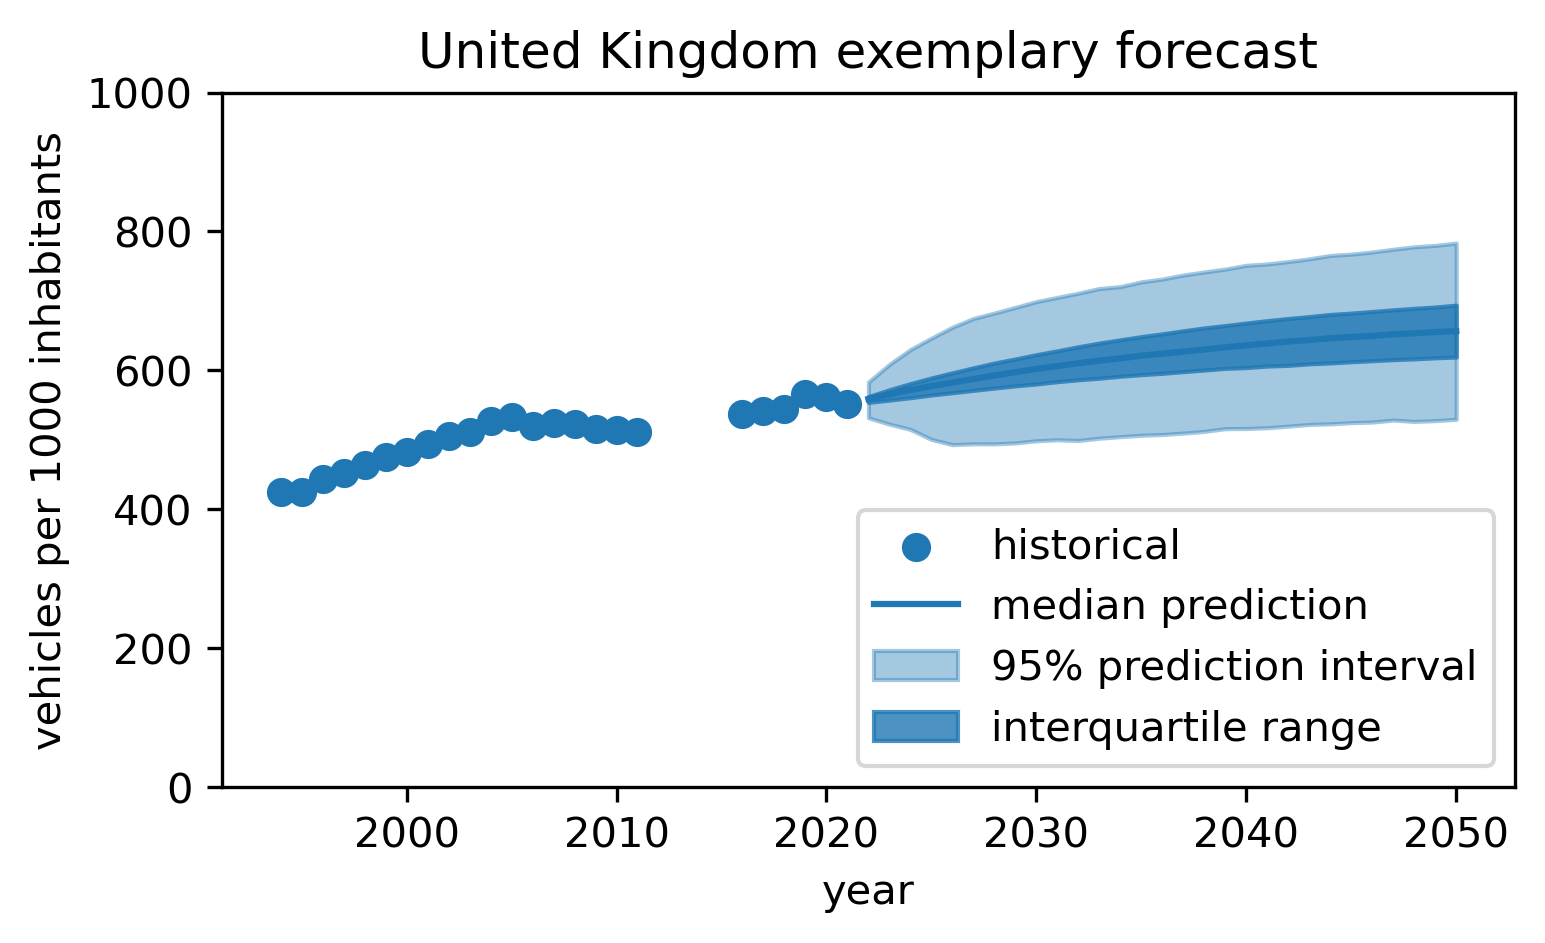

In [65]:
fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)
ax.scatter(data_test["Year"],data_test["VEHICLE-STOCK-PER-CAP"],label="historical")
#ax.plot(gdp_gbr[1:],lower[1:])
ax.plot(years,predict[1:],label="median prediction")
ax.fill_between(years, upper[1:], lower[1:],color="tab:blue",alpha = 0.4,label="95% prediction interval")
ax.fill_between(years, iq_upper[1:], iq_lower[1:],color="tab:blue",alpha = 0.8,label="interquartile range")
ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("vehicles per 1000 inhabitants")
ax.set_title("United Kingdom exemplary forecast")
ax.legend(loc="lower right")
fig.tight_layout()

fig.savefig("results/GBR.jpg")

In [66]:
#forecast the past...
# construct prediction intervals
data_test =  data.loc[(data["Country Code"]=="GBR")]
bootstrap_preds = np.zeros((len(data_test),len(bootstrap_fits)))
bootstrap_preds[0,:] = data.loc[(data["Country Code"]=="GBR")&(data["Year"]==1994)]["VEHICLE-STOCK-PER-CAP"].values[0]
upper = np.zeros(len(data_test))
lower = np.zeros(len(data_test))
predict = np.zeros(len(data_test))
likely_percentile = 50
alpha = 0.05

for i in range(len(data_test)):
    if i >0 :
        for j,bf in enumerate(bootstrap_fits):
            bootstrap_preds[i,j] = vehicle_ownership(*bf[0:7],bf[beta_0_idx+betas_order["GBR"]],data_test["POP-DENS"].values[i],
                                                    data_test["URBAN-POP-PERC"].values[i],
                                                    data_test["URBAN-POP-DENS"].values[i],data_test["GDP_rising"].values[i],
                                                    data_test["GDP_falling"].values[i],data_test["GDP-PER-CAP"].values[i],bootstrap_preds[i-1,j])+draw_residual_from_percentiles(residuals)
    
    #C = np.array([m + o for m in bootstrap_preds[i,:] for o in residuals])
    C = np.array(bootstrap_preds[i,:])
    # if i==1:
    #     likely_percentile = stats.percentileofscore(C,bootstrap_preds[0,0] )
    #     print(likely_percentile)
    qs = [100 * alpha / 2, 100 * (1 - alpha / 2),likely_percentile]
    percentiles = np.percentile(C, q = qs)
    upper[i] = percentiles[1]
    lower[i] = percentiles[0]
    predict[i] = percentiles[2]

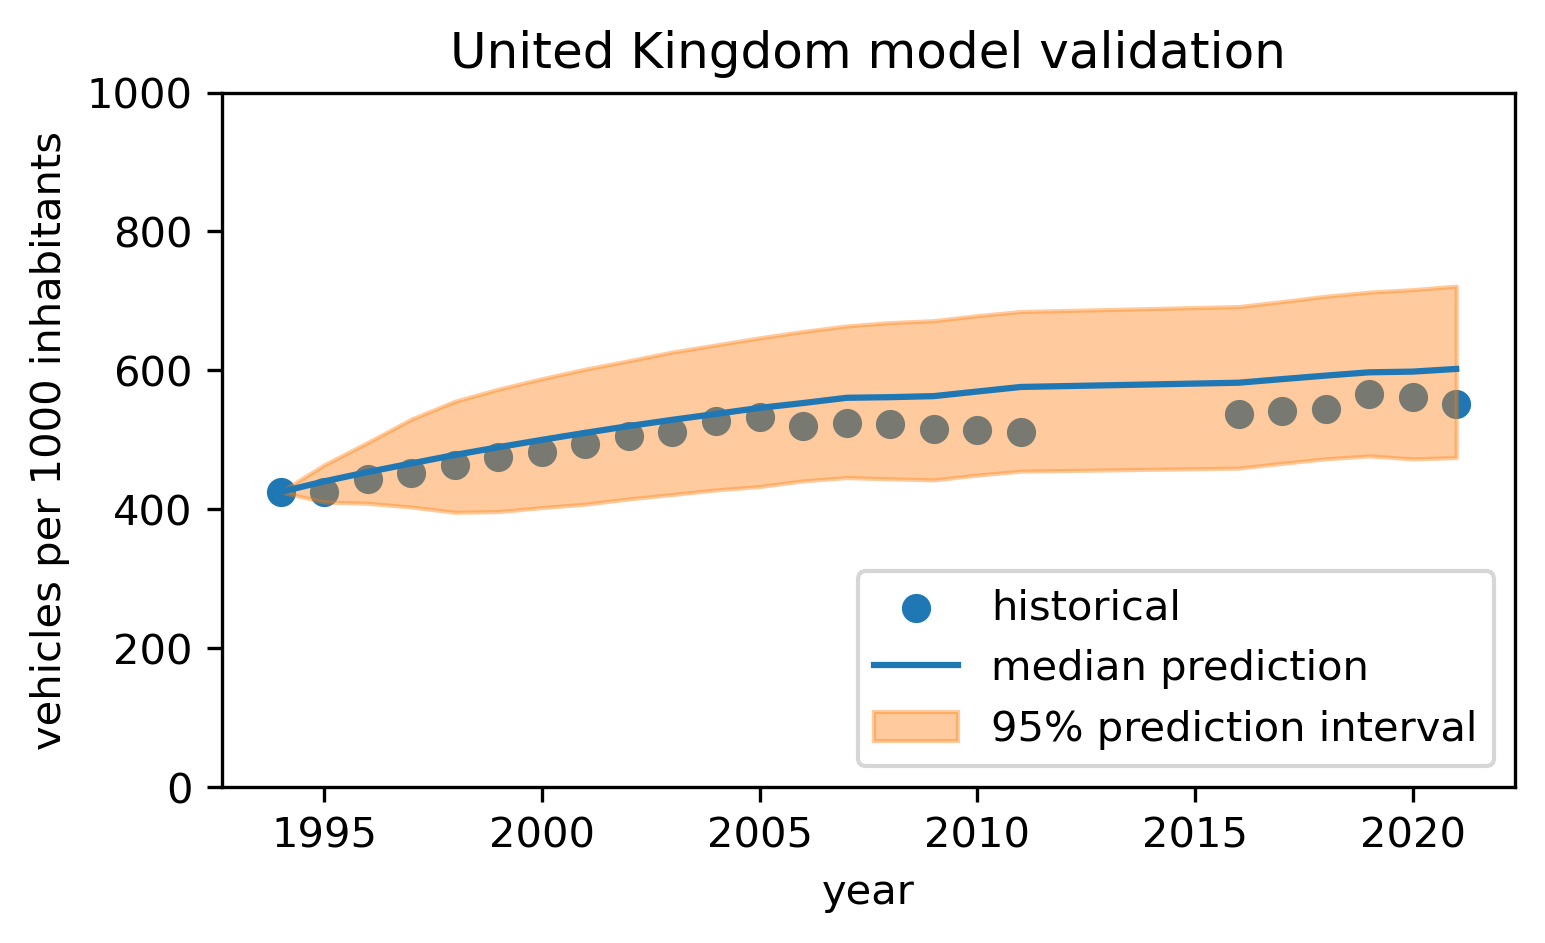

In [67]:
fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)
ax.scatter(data_test["Year"],data_test["VEHICLE-STOCK-PER-CAP"],label="historical")
#ax.plot(gdp_gbr[1:],lower[1:])
ax.plot(data_test["Year"],predict,label="median prediction")
ax.fill_between(data_test["Year"], upper, lower,color="tab:orange",alpha = 0.4,label="95% prediction interval")
ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("vehicles per 1000 inhabitants")
ax.set_title("United Kingdom model validation")
ax.legend(loc="lower right")
fig.tight_layout()

fig.savefig("results/GBR_validation.jpg")

In [68]:
# construct prediction intervals
bootstrap_preds = np.zeros((len(gdp_chn),len(bootstrap_fits)))
data_test =  data.loc[(data["Country Code"]=="CHN")]
bootstrap_preds[0,:] = data.loc[(data["Country Code"]=="CHN")&(data["Year"]==2021)]["VEHICLE-STOCK-PER-CAP"].values[0]
upper = np.zeros(len(gdp_chn))
lower = np.zeros(len(gdp_chn))
iq_upper = np.zeros(len(gdp_chn))
iq_lower = np.zeros(len(gdp_chn))
predict = np.zeros(len(gdp_chn))
likely_percentile = 50
alpha = 0.05
for i in range(1,len(gdp_chn)):
    for j,bf in enumerate(bootstrap_fits):
        bootstrap_preds[i,j] = vehicle_ownership(*bf[0:7],bf[beta_0_idx+betas_order["CHN"]],data_test["POP-DENS"].values[-1],
                                                 data_test["URBAN-POP-PERC"].values[-1],
                                                data_test["URBAN-POP-DENS"].values[-1],1,0,gdp_chn[i],bootstrap_preds[i-1,j])+draw_residual_from_percentiles(residuals)
    
    #C = np.array([m + o for m in bootstrap_preds[i,:] for o in residuals])
    C = np.array(bootstrap_preds[i,:])
    # if i==1:
    #     likely_percentile = stats.percentileofscore(C,bootstrap_preds[0,0] )
    #     print(likely_percentile)
    qs = [100 * alpha / 2, 100 * (1 - alpha / 2),likely_percentile,25,75]
    percentiles = np.percentile(C, q = qs)
    upper[i] = percentiles[1]
    lower[i] = percentiles[0]
    predict[i] = percentiles[2]
    iq_upper[i] = percentiles[4]
    iq_lower[i] = percentiles[3]

In [69]:
data_test

,Unnamed: 0,Country Code,Year,GDP,POP,POP-DENS,URBAN-POP-PERC,URBAN-POP-DENS,GDP_rising,GDP_falling,VEHICLE-STOCK,VEHICLE-STOCK-LAST,GDP-PER-CAP,VEHICLE-STOCK-PER-CAP,VEHICLE-STOCK-LAST-PER-CAP
659,3475,CHN,2006,4.982880e+12,1.311020e+09,139.104693,43.868,1221.142622,1,0,26195700.0,21324500.0,3.800766,19.981160,16.265579
717,3690,CHN,2007,5.691987e+12,1.317885e+09,139.833098,45.199,1249.634741,1,0,31959900.0,26195700.0,4.319032,24.250902,19.877076
776,3905,CHN,2008,6.241302e+12,1.324655e+09,140.551423,46.539,1277.986844,1,0,38389100.0,31959900.0,4.711644,28.980452,24.126961
841,4120,CHN,2009,6.827905e+12,1.331260e+09,141.252234,47.880,1305.912888,1,0,48450900.0,38389100.0,5.128904,36.394769,28.836666
908,4335,CHN,2010,7.554112e+12,1.337705e+09,141.936072,49.226,1333.527952,1,0,61241200.0,48450900.0,5.647069,45.780796,36.219421
974,4550,CHN,2011,8.275593e+12,1.345035e+09,142.713813,50.511,1360.112609,1,0,74783700.0,61241200.0,6.152697,55.599817,45.531306
1044,4765,CHN,2012,8.926364e+12,1.354190e+09,143.685196,51.765,1387.509456,1,0,89430099.0,74783700.0,6.591663,66.039551,55.223935
1115,4980,CHN,2013,9.619599e+12,1.363240e+09,144.645433,53.013,1414.474431,1,0,105617700.0,89430099.0,7.056423,77.475500,65.601141
1185,5195,CHN,2014,1.033393e+13,1.371860e+09,145.560051,54.259,1440.776002,1,0,123267000.0,105617700.0,7.532786,89.853921,76.988687
1251,5410,CHN,2015,1.106157e+13,1.379860e+09,146.408883,55.500,1466.123019,1,0,140958700.0,123267000.0,8.016446,102.154349,89.332976


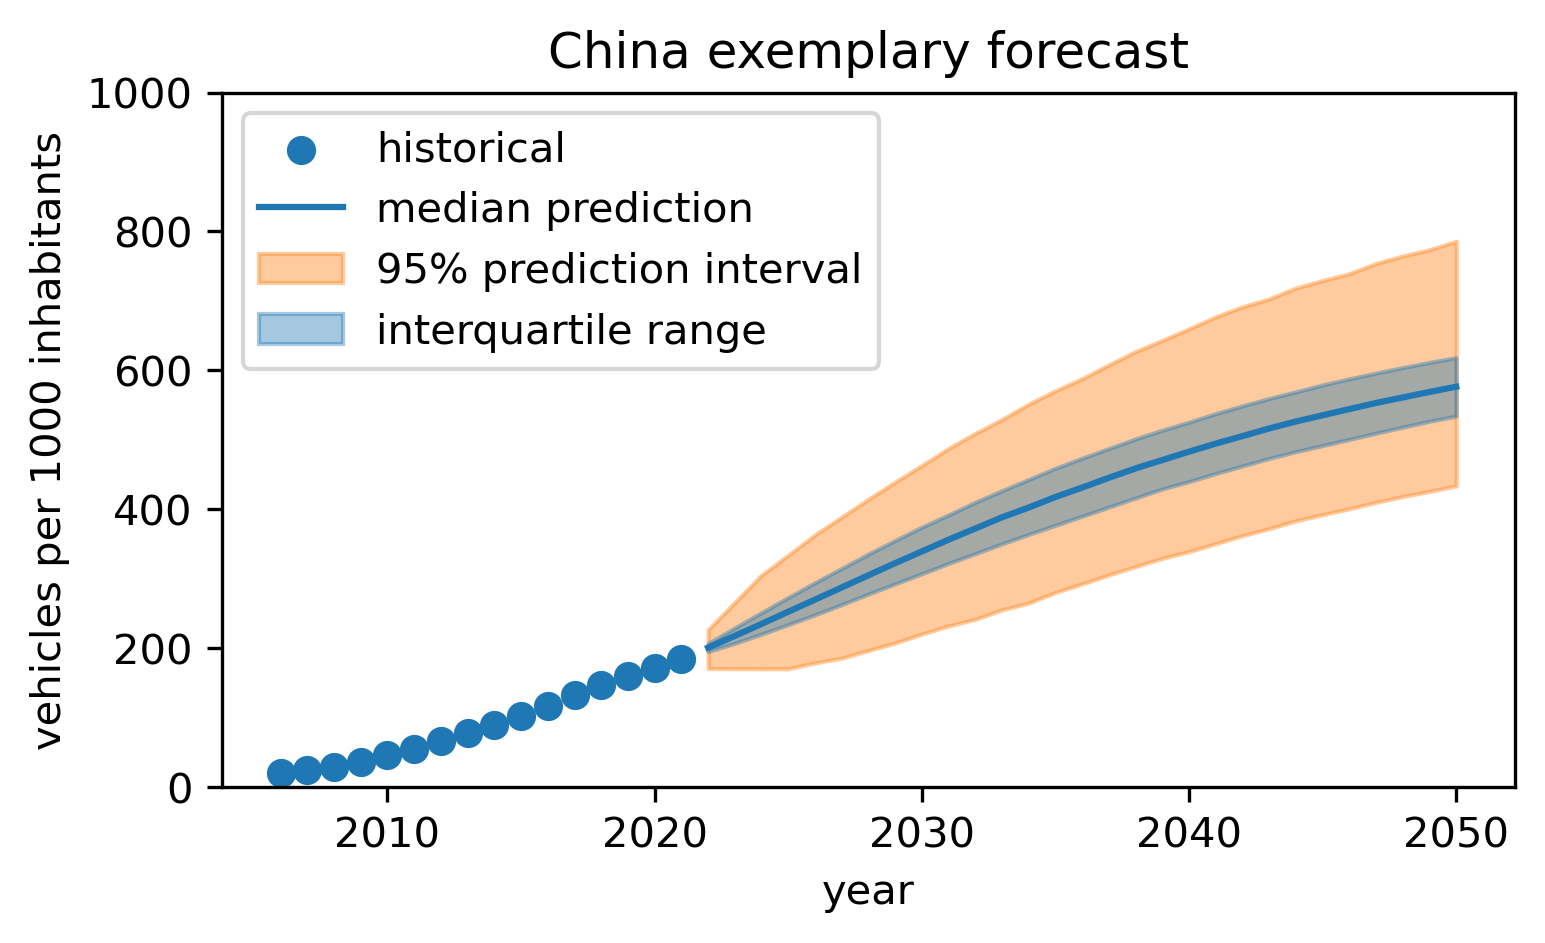

In [70]:
fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)
ax.scatter(data_test["Year"],data_test["VEHICLE-STOCK-PER-CAP"],label="historical")
#ax.plot(gdp_gbr[1:],lower[1:])
ax.plot(years,predict[1:],label="median prediction")
ax.fill_between(years, upper[1:], lower[1:],color="tab:orange",alpha = 0.4,label="95% prediction interval")
ax.fill_between(years, iq_upper[1:], iq_lower[1:],color="tab:blue",alpha = 0.4,label="interquartile range")

ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("vehicles per 1000 inhabitants")
ax.set_title("China exemplary forecast")
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig("results/CHN.jpg")

In [71]:
#forecast the past...
# construct prediction intervals
data_test =  data.loc[(data["Country Code"]=="CHN")]
bootstrap_preds = np.zeros((len(data_test),len(bootstrap_fits)))
bootstrap_preds[0,:] = data.loc[(data["Country Code"]=="CHN")&(data["Year"]==2006)]["VEHICLE-STOCK-PER-CAP"].values[0]
upper = np.zeros(len(data_test))
lower = np.zeros(len(data_test))
iq_upper = np.zeros(len(data_test))
iq_lower = np.zeros(len(data_test))
predict = np.zeros(len(data_test))
likely_percentile = 50
alpha = 0.05

for i in range(len(data_test)):
    if i >0 :
        for j,bf in enumerate(bootstrap_fits):
            bootstrap_preds[i,j] = max(0,vehicle_ownership(*bf[0:7],bf[beta_0_idx+betas_order["CHN"]],data_test["POP-DENS"].values[i],
                                                    data_test["URBAN-POP-PERC"].values[i],
                                                    data_test["URBAN-POP-DENS"].values[i],data_test["GDP_rising"].values[i],
                                                    data_test["GDP_falling"].values[i],data_test["GDP-PER-CAP"].values[i],bootstrap_preds[i-1,j])+draw_residual_from_percentiles(residuals))
    
    #C = np.array([m + o for m in bootstrap_preds[i,:] for o in residuals])
    C = np.array(bootstrap_preds[i,:])

    # if i == 0:
    #     C = bootstrap_preds[i,:]
    # else:
    #     C = np.array([m + o for m in bootstrap_preds[i,:] for o in residuals])
    # if i==1:
    #     likely_percentile = stats.percentileofscore(C,bootstrap_preds[0,0] )
    #     print(likely_percentile)
    qs = [100 * alpha / 2, 100 * (1 - alpha / 2),likely_percentile,25,75]
    percentiles = np.percentile(C, q = qs)
    upper[i] = percentiles[1]
    lower[i] = percentiles[0]
    predict[i] = percentiles[2]
    iq_upper[i] = percentiles[4]
    iq_lower[i] = percentiles[3]

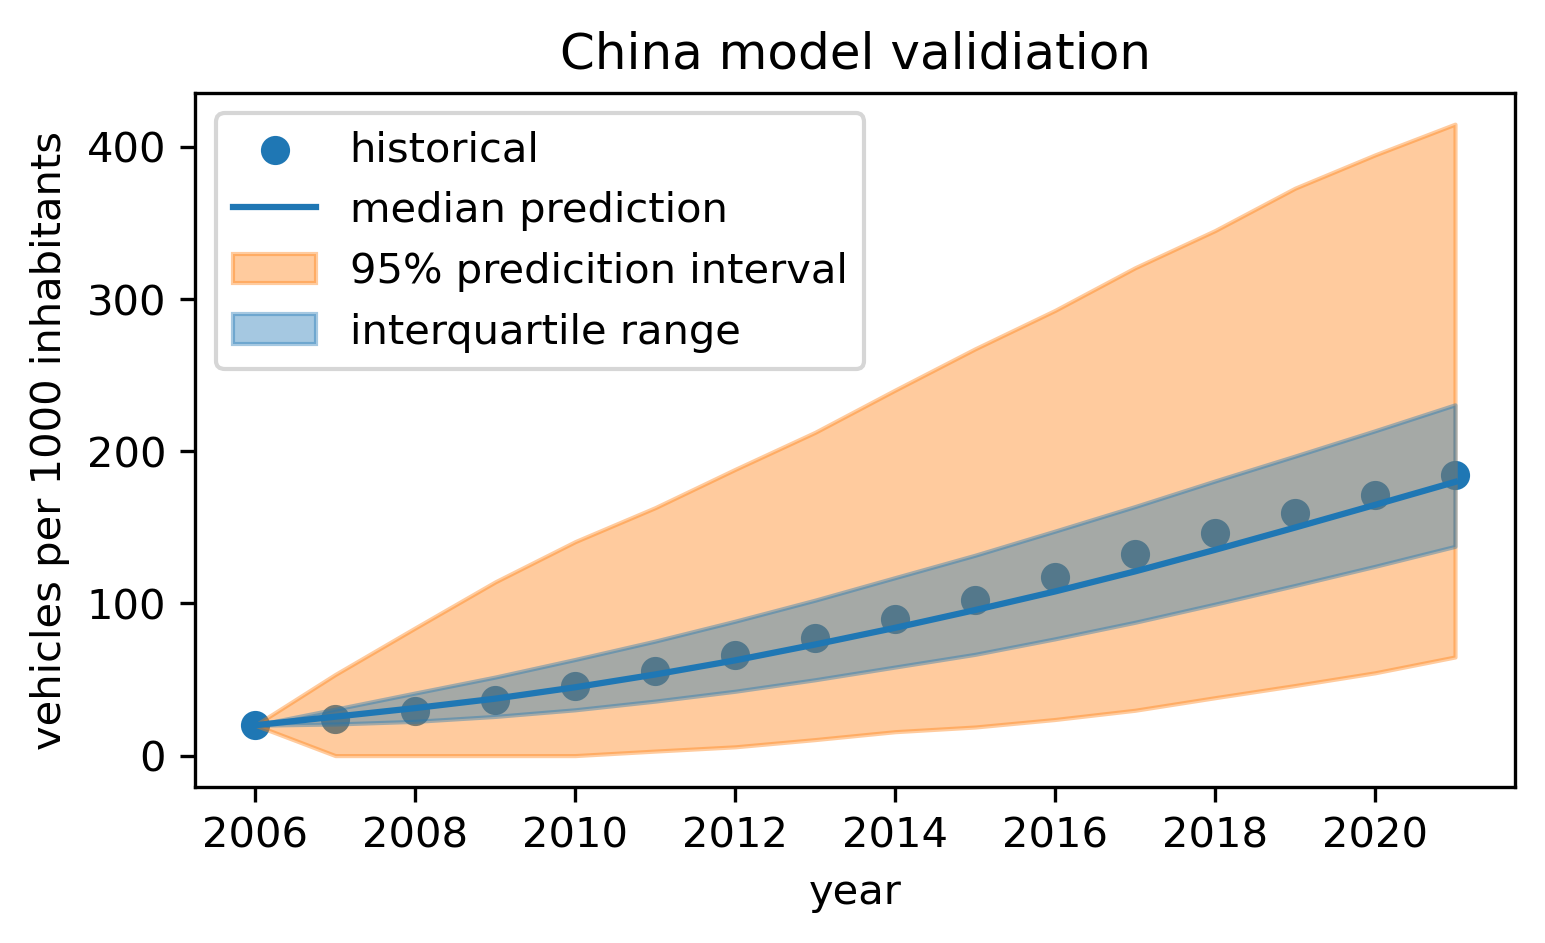

In [72]:
fig,ax = plt.subplots(figsize=[3.5*1.5,3.5*1.5/1.618],dpi=300)
ax.scatter(data_test["Year"],data_test["VEHICLE-STOCK-PER-CAP"],label="historical")
#ax.plot(gdp_gbr[1:],lower[1:])
ax.plot(data_test["Year"],predict,label="median prediction")
ax.fill_between(data_test["Year"], upper, lower,color="tab:orange",alpha = 0.4,label="95% predicition interval")
ax.fill_between(data_test["Year"], iq_upper, iq_lower,color="tab:blue",alpha = 0.4,label="interquartile range")

#ax.set_ylim([0,1000])
ax.set_xlabel("year")
ax.set_ylabel("vehicles per 1000 inhabitants")
ax.set_title("China model validiation")
ax.legend(loc="upper left")
fig.tight_layout()

fig.savefig("results/CHN_validation.jpg")